In [1]:
import os
import json
from itertools import groupby
from torch.optim import Adam
from torch.nn import functional as nnf
from torchvision.transforms import functional as transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
from torch import nn

import matplotlib.pyplot as plt

import numpy as np
from os.path import join, isdir, expanduser
from PIL import Image

data_path = expanduser('~/datasets')

In [2]:
num_images = 1000

trainA_path = ["horse2zebra", "trainA"]
trainB_path = ["horse2zebra", "trainB"]

train_cat_files = os.listdir(join(data_path, *trainA_path))
train_dog_files = os.listdir(join(data_path, *trainB_path))


train_A_raw = [Image.open(join(data_path, *trainA_path, f))
          for f in tqdm(train_cat_files[:num_images], desc="A loading") if f.endswith('.jpg')]

train_B_raw = [Image.open(join(data_path, *trainB_path, f))
          for f in tqdm(train_dog_files[:num_images], desc="B loading") if f.endswith('.jpg')]


trans = ToTensor()

train_A = [trans(img) for img in tqdm(train_A_raw, desc="A processing") if trans(img).shape == (3, 256, 256)]
train_B = [trans(img) for img in tqdm(train_B_raw, desc="B processing") if trans(img).shape == (3, 256, 256)]

min_len = min(len(train_A), len(train_B))
train_A = train_A[:min_len]
train_B = train_B[:min_len]

B processing: 100%|█████████████████████████| 1000/1000 [01:00<00:00, 16.57it/s]


In [3]:
batch_size = 32

A_loader = torch.utils.data.DataLoader(train_A, batch_size=batch_size, shuffle=True, drop_last=True)
B_loader = torch.utils.data.DataLoader(train_B, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        conv1 = nn.Conv2d(channels, channels, 3)
        bn1 = nn.BatchNorm2d(channels)
        relu = nn.ReLU()
        conv2 = nn.Conv2d(channels, channels, 3)
        bn2 = nn.BatchNorm2d(channels)
        
        self.Layers = nn.Sequential(conv1, bn1, relu, conv2, bn2)
        
    def forward(self, x):
        x_crop = x[:,:,2:-2,2:-2]
        return self.Layers(x) + x_crop
    

resblock = ResBlock(128)

dummydata = torch.randn([16,128,84,84])
resblock(dummydata).shape

torch.Size([16, 128, 80, 80])

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.padder =  nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        
        self.resblocks = nn.Sequential(*[ResBlock(128) for _ in range(5)])
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size= 2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size= 2, stride=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size= 9, stride=1, padding="same")
    
    def forward(self, x):
        for layer in [self.padder, self.conv1, self.conv2, self.conv3]:
            x = layer(x)
            
        x =  self.resblocks(x)
        
        x = nn.Tanh()(self.conv4(self.upconv2(self.upconv1(x))))
        
        return x
    
gen = Generator().cuda()
dummydata = torch.randn([64,3,128,128]).cuda()
gen(dummydata).shape

del gen
del dummydata

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self, d=64):
        super().__init__()
        
        self.lrelu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
       
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(d * 8,1)
        self.sig = nn.Sigmoid()
        
        
        

    def forward(self, x):
        
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2_bn(self.conv2(x)))
        x = self.lrelu(self.conv3_bn(self.conv3(x)))
        x = self.lrelu(self.conv4_bn(self.conv4(x)))
        
        x = self.sig((self.linear(self.flatten(self.pool(x)))))

        return x

        
dis = Discriminator(64).cuda()
dummydata = torch.randn([64,3,128,128]).cuda()
print(dis(dummydata).shape)


del dis
del dummydata

torch.Size([64, 1])


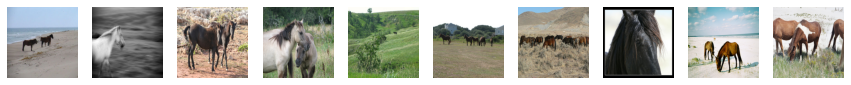

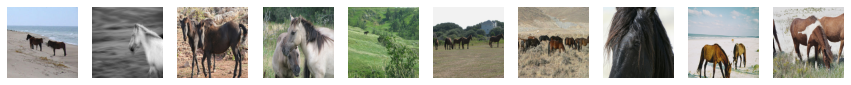

In [7]:
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, Compose, InterpolationMode

transform_pipeline = Compose([
    RandomCrop(200),
    RandomHorizontalFlip(p=0.5),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Resize(128, InterpolationMode.BICUBIC)
])

def unprocess(img):
    img = img.permute(1,2,0)
    img = img - img.min()
    return img / img.max()

def show(images):
    l = len(images)
   
    _, axs = plt.subplots(1, l, figsize=(15,7))
    for i, img in enumerate(images):
        axs[i].imshow(unprocess(img))
        axs[i].axis('off')
    plt.show()

test = next(iter(A_loader))
    
res = transform_pipeline(test)
show(test[:10])
show(res[:10])

In [8]:
G_ab = Generator().cuda()
G_ba = Generator().cuda()

D_a = Discriminator(d=128).cuda()
D_b = Discriminator(d=128).cuda()

opt_G = Adam(list(G_ab.parameters()) + list(G_ba.parameters()), lr=0.0002, betas=(0.5, 0.999))
opt_D_a = Adam(D_a.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_D_b = Adam(D_b.parameters(), lr=0.0001, betas=(0.5, 0.999))
losses = [[], [], []]

In [ ]:
epochs = 40

for i in range(epochs):
    
    for a_batch, b_batch in zip(A_loader, B_loader):

        a_batch = transform_pipeline(a_batch).cuda().float()
        b_batch = transform_pipeline(b_batch).cuda().float()

        ones, zeros = torch.ones(batch_size,1).cuda(), torch.zeros(batch_size,1).cuda()
        # train generators

        opt_G.zero_grad()

        G_ab.train()
        G_ba.train()

        # if input is from right distribution (or class) already: don't change it
        loss_eye = (nnf.l1_loss(G_ba(a_batch), a_batch) + nnf.l1_loss(G_ab(b_batch), b_batch)) / 2

        # let's fool the discriminator a bit...
        fake_a, fake_b = G_ba(b_batch), G_ab(a_batch)
        loss_fool_d = (nnf.mse_loss(D_a(fake_a), ones) + nnf.mse_loss(D_b(fake_b), ones)) / 2

        # by applying the generators twice we should be back at the initial sample
        loss_cycle = (nnf.l1_loss(G_ba(fake_b), a_batch) + nnf.l1_loss(G_ab(fake_a), b_batch)) / 2

        loss_g = 5 * loss_eye  + loss_cycle * 10 + loss_fool_d
        loss_g.backward()
        opt_G.step()

        # train discriminator A
        opt_D_a.zero_grad()
        loss_d_a = 0.5 * nnf.mse_loss(D_a(a_batch), ones)
        loss_d_a += 0.5 * nnf.mse_loss(D_a(fake_a.detach()), zeros)
        loss_d_a.backward()
        opt_D_a.step()

        # train discriminator B
        opt_D_b.zero_grad()
        loss_d_b = 0.5 * nnf.mse_loss(D_b(b_batch), ones)
        loss_d_b += 0.5 * nnf.mse_loss(D_b(fake_b.detach()), zeros)
        loss_d_b.backward()
        opt_D_b.step()

        losses[0] += [float(loss_g)]
        losses[1] += [float(loss_d_a)]
        losses[2] += [float(loss_d_b)]
        
        del a_batch
        del b_batch
        torch.cuda.empty_cache()        
        

    print(f'generator: {np.mean(losses[0]):.5f}, D_a: {np.mean(losses[1]):.5f}, D_b: {np.mean(losses[2]):.5f}')


generator: 2.08651, D_a: 0.15933, D_b: 0.13184
generator: 2.08454, D_a: 0.15929, D_b: 0.13157
generator: 2.08313, D_a: 0.15916, D_b: 0.13129
generator: 2.08141, D_a: 0.15913, D_b: 0.13101
generator: 2.08001, D_a: 0.15899, D_b: 0.13075
generator: 2.07824, D_a: 0.15896, D_b: 0.13048
generator: 2.07713, D_a: 0.15889, D_b: 0.13013
generator: 2.07545, D_a: 0.15888, D_b: 0.12988
generator: 2.07390, D_a: 0.15877, D_b: 0.12950
generator: 2.07234, D_a: 0.15869, D_b: 0.12926
generator: 2.07070, D_a: 0.15861, D_b: 0.12901
generator: 2.06928, D_a: 0.15852, D_b: 0.12864
generator: 2.06795, D_a: 0.15846, D_b: 0.12838
generator: 2.06669, D_a: 0.15830, D_b: 0.12803
generator: 2.06561, D_a: 0.15819, D_b: 0.12769
generator: 2.06453, D_a: 0.15808, D_b: 0.12734
generator: 2.06377, D_a: 0.15809, D_b: 0.12685
generator: 2.06262, D_a: 0.15799, D_b: 0.12646
generator: 2.06124, D_a: 0.15788, D_b: 0.12622
generator: 2.05996, D_a: 0.15782, D_b: 0.12592
generator: 2.05865, D_a: 0.15776, D_b: 0.12558
generator: 2.

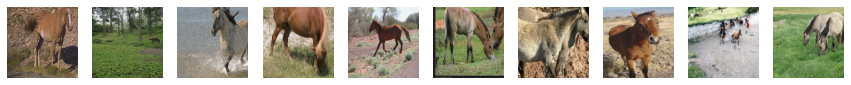

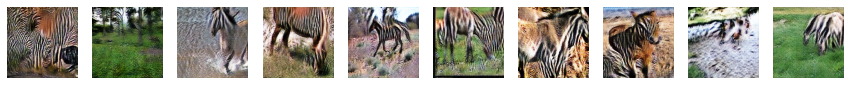

In [16]:
test_a = next(iter(A_loader))
test_a = transform_pipeline(test_a)

show(test_a[:10])

res = G_ab(test_a[:10].cuda()).cpu().detach()
show(res)

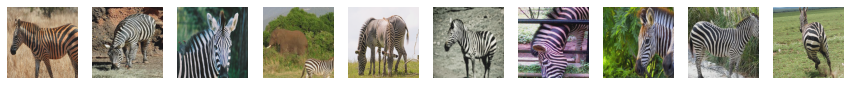

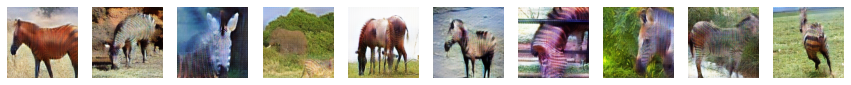

In [17]:
test_b = next(iter(B_loader))
test_b = transform_pipeline(test_b)

show(test_b[:10])

res = G_ba(test_b[:10].cuda()).cpu().detach()
show(res)